In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
aws_df = pd.read_csv("../data/realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv")
aws_df

,timestamp,value
0,2014-02-14 14:27:00,51.846
1,2014-02-14 14:32:00,44.508
2,2014-02-14 14:37:00,41.244
3,2014-02-14 14:42:00,48.568
4,2014-02-14 14:47:00,46.714
...,...,...
4027,2014-02-28 14:02:00,38.474
4028,2014-02-28 14:07:00,40.352
4029,2014-02-28 14:12:00,37.912
4030,2014-02-28 14:17:00,38.458


In [5]:
aws_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB


In [6]:
aws_df["timestamp"] = pd.to_datetime(aws_df["timestamp"])

In [7]:
aws_df = aws_df.sort_values("timestamp").reset_index(drop=True)

In [8]:
aws_df.isnull().sum()

timestamp    0
value        0
dtype: int64

In [9]:
aws_df.dtypes

timestamp    datetime64[ns]
value               float64
dtype: object

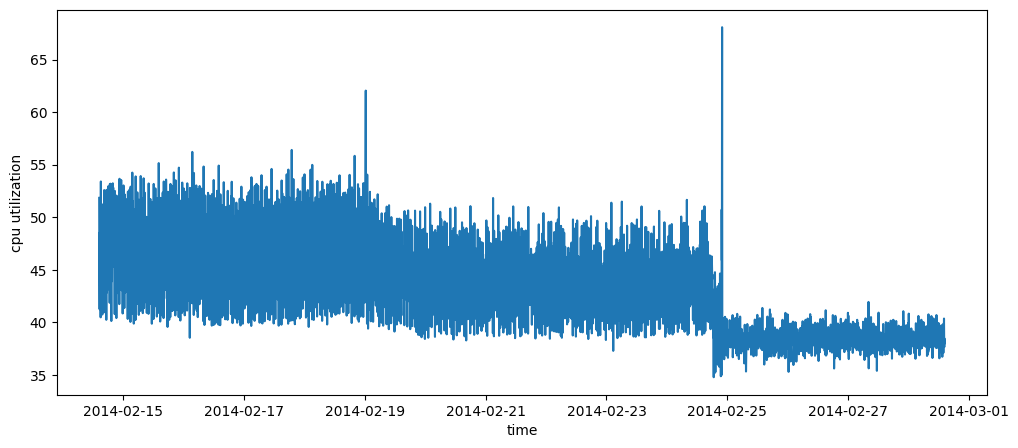

In [11]:
plt.figure(figsize=(12,5))

plt.plot(aws_df["timestamp"], aws_df["value"])
plt.ylabel("cpu utilization")
plt.xlabel("time")
plt.show()

In [16]:
X_aws = aws_df[["value"]].values
X_aws.shape

(4032, 1)

In [17]:
# model training

In [18]:
from sklearn.ensemble import IsolationForest

In [19]:
iso_model = IsolationForest(
    n_estimators = 100,
    contamination = 0.05,
    random_state=42
)

In [20]:
iso_model.fit(X_aws)

,"n_estimators n_estimators: int, default=100The number of base estimators in the ensemble.",100
,"max_samples max_samples: ""auto"", int or float, default=""auto""The number of samples to draw from X to train each base estimator.- If int, then draw `max_samples` samples.- If float, then draw `max_samples * X.shape[0]` samples.- If ""auto"", then `max_samples=min(256, n_samples)`.If max_samples is larger than the number of samples provided,all samples will be used for all trees (no sampling).",'auto'
,"contamination contamination: 'auto' or float, default='auto'The amount of contamination of the data set, i.e. the proportionof outliers in the data set. Used when fitting to define the thresholdon the scores of the samples.- If 'auto', the threshold is determined as in the original paper.- If float, the contamination should be in the range (0, 0.5]... versionchanged:: 0.22 The default value of ``contamination`` changed from 0.1 to ``'auto'``.",0.05
,"max_features max_features: int or float, default=1.0The number of features to draw from X to train each base estimator.- If int, then draw `max_features` features.- If float, then draw `max(1, int(max_features * n_features_in_))` features.Note: using a float number less than 1.0 or integer less than number offeatures will enable feature subsampling and leads to a longer runtime.",1.0
,"bootstrap bootstrap: bool, default=FalseIf True, individual trees are fit on random subsets of the trainingdata sampled with replacement. If False, sampling without replacementis performed.",False
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for :meth:`fit`. ``None`` means 1unless in a :obj:`joblib.parallel_backend` context. ``-1`` means usingall processors. See :term:`Glossary ` for more details.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the pseudo-randomness of the selection of the featureand split values for each branching step and each tree in the forest.Pass an int for reproducible results across multiple function calls.See :term:`Glossary `.",42
,"verbose verbose: int, default=0Controls the verbosity of the tree building process.",0
,"warm_start warm_start: bool, default=FalseWhen set to ``True``, reuse the solution of the previous call to fitand add more estimators to the ensemble, otherwise, just fit a wholenew forest. See :term:`the Glossary `... versionadded:: 0.21",False


In [21]:
aws_df["anomaly"] = iso_model.predict(X_aws)

In [23]:
aws_df["anomaly"].value_counts()

anomaly
 1    3830
-1     202
Name: count, dtype: int64

In [41]:
normal_aws = aws_df[aws_df["anomaly"]==1]

In [42]:
anomaly_aws = aws_df[aws_df["anomaly"]== -1]

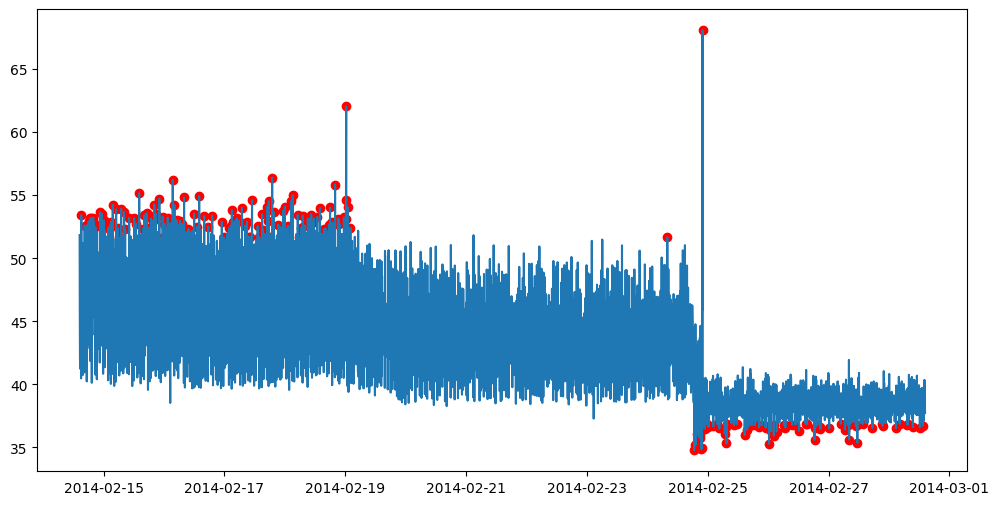

In [43]:
plt.figure(figsize = (12,6))

plt.plot(aws_df["timestamp"], aws_df["value"])

plt.scatter(anomaly_aws["timestamp"], anomaly_aws["value"], color ="red")


In [44]:
# Sort anomaly points by time

In [45]:
anomaly_aws = anomaly_aws.sort_values("timestamp").reset_index(drop=True)
anomaly_aws

,timestamp,value,anomaly
0,2014-02-14 15:07:00,53.404,-1
1,2014-02-14 16:27:00,52.586,-1
2,2014-02-14 17:22:00,52.606,-1
3,2014-02-14 18:02:00,52.940,-1
4,2014-02-14 18:42:00,53.170,-1
...,...,...,...
197,2014-02-28 07:22:00,36.792,-1
198,2014-02-28 07:32:00,36.882,-1
199,2014-02-28 09:32:00,36.596,-1
200,2014-02-28 12:17:00,36.568,-1


In [46]:
# Calculate time difference

In [47]:
anomaly_aws["time_diff"] = anomaly_aws["timestamp"].diff()

In [48]:
anomaly_aws

,timestamp,value,anomaly,time_diff
0,2014-02-14 15:07:00,53.404,-1,NaT
1,2014-02-14 16:27:00,52.586,-1,0 days 01:20:00
2,2014-02-14 17:22:00,52.606,-1,0 days 00:55:00
3,2014-02-14 18:02:00,52.940,-1,0 days 00:40:00
4,2014-02-14 18:42:00,53.170,-1,0 days 00:40:00
...,...,...,...,...
197,2014-02-28 07:22:00,36.792,-1,0 days 03:00:00
198,2014-02-28 07:32:00,36.882,-1,0 days 00:10:00
199,2014-02-28 09:32:00,36.596,-1,0 days 02:00:00
200,2014-02-28 12:17:00,36.568,-1,0 days 02:45:00


In [49]:
# Incident boundary for 10 mins

In [54]:
threshold = pd.Timedelta(minutes=10)

anomaly_aws["new_incident"] = (
    anomaly_aws["time_diff"].isna() | (anomaly_aws["time_diff"]>threshold)
)

In [55]:
anomaly_aws

,timestamp,value,anomaly,time_diff,new_incident
0,2014-02-14 15:07:00,53.404,-1,NaT,True
1,2014-02-14 16:27:00,52.586,-1,0 days 01:20:00,True
2,2014-02-14 17:22:00,52.606,-1,0 days 00:55:00,True
3,2014-02-14 18:02:00,52.940,-1,0 days 00:40:00,True
4,2014-02-14 18:42:00,53.170,-1,0 days 00:40:00,True
...,...,...,...,...,...
197,2014-02-28 07:22:00,36.792,-1,0 days 03:00:00,True
198,2014-02-28 07:32:00,36.882,-1,0 days 00:10:00,False
199,2014-02-28 09:32:00,36.596,-1,0 days 02:00:00,True
200,2014-02-28 12:17:00,36.568,-1,0 days 02:45:00,True


In [56]:
anomaly_aws["incident_id"] = anomaly_aws["new_incident"].cumsum()

In [57]:
anomaly_aws

,timestamp,value,anomaly,time_diff,new_incident,incident_id
0,2014-02-14 15:07:00,53.404,-1,NaT,True,1
1,2014-02-14 16:27:00,52.586,-1,0 days 01:20:00,True,2
2,2014-02-14 17:22:00,52.606,-1,0 days 00:55:00,True,3
3,2014-02-14 18:02:00,52.940,-1,0 days 00:40:00,True,4
4,2014-02-14 18:42:00,53.170,-1,0 days 00:40:00,True,5
...,...,...,...,...,...,...
197,2014-02-28 07:22:00,36.792,-1,0 days 03:00:00,True,184
198,2014-02-28 07:32:00,36.882,-1,0 days 00:10:00,False,184
199,2014-02-28 09:32:00,36.596,-1,0 days 02:00:00,True,185
200,2014-02-28 12:17:00,36.568,-1,0 days 02:45:00,True,186


In [58]:
# Count Aws incident

In [59]:
anomaly_aws["incident_id"].nunique()

187

In [60]:
# Incident summary table

In [61]:
aws_incident_summary = (
    anomaly_aws.groupby("incident_id").agg(
        start_time = ("timestamp","min"),
        end_time = ("timestamp","max"),
        num_points = ("timestamp","count")
    ).reset_index()
)

In [62]:
aws_incident_summary["duration_minutes"] = (
    aws_incident_summary["end_time"] - aws_incident_summary["start_time"]
).dt.total_seconds() / 60

In [63]:
aws_incident_summary["duration_minutes"].describe()

count    187.000000
mean       0.721925
std        2.912284
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max       20.000000
Name: duration_minutes, dtype: float64